In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data_dir = 'data' #data from polybox (ASV, taxonomy analysis)
or_dir = '../data'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

In [2]:
! wget -nv -O $data_dir/taxonomy_classification.qzv 'https://polybox.ethz.ch/index.php/s/c3rjz7z9GBUXvE8/download'
! wget -nv -O $data_dir/taxonomy_classification.qza 'https://polybox.ethz.ch/index.php/s/X8AoIryeOnLaCn5/download'
! wget -nv -O $data_dir/PJNB_dada2_table-filtered.qza 'https://polybox.ethz.ch/index.php/s/q2dsg2JxeJz3hko/download'
! wget -nv -O $data_dir/PJNB_dada2_rep_set-filtered.qza 'https://polybox.ethz.ch/index.php/s/vtDJzaCrmebL2u7/download'

2022-11-15 17:48:55 URL:https://polybox.ethz.ch/index.php/s/c3rjz7z9GBUXvE8/download [1967910/1967910] -> "data/taxonomy_classification.qzv" [1]
2022-11-15 17:48:55 URL:https://polybox.ethz.ch/index.php/s/X8AoIryeOnLaCn5/download [397957/397957] -> "data/taxonomy_classification.qza" [1]
2022-11-15 17:48:56 URL:https://polybox.ethz.ch/index.php/s/q2dsg2JxeJz3hko/download [1818719/1818719] -> "data/PJNB_dada2_table-filtered.qza" [1]
2022-11-15 17:48:56 URL:https://polybox.ethz.ch/index.php/s/vtDJzaCrmebL2u7/download [552613/552613] -> "data/PJNB_dada2_rep_set-filtered.qza" [1]


In [2]:
metadata = pd.read_csv(or_dir + '/metadata.tsv', sep = '\t')

In [3]:
print(metadata.shape, ' the number of samples we have and metadata variables that were collected')
print(metadata['host_id'].nunique(), ' unique hosts tracked over time') # number of hosts that were followed over time

(1669, 26)
80


In [63]:
taxonomic_assignments = pd.read_csv(data_dir+'/taxonomic_assignments.csv', index_col = 0) # import metadata with taxonomic assignment dataframe
#print(taxonomic_assignments.head())
taxonomic_assignments = taxonomic_assignments[taxonomic_assignments['diet_milk'] != 'no milk']
# REMOVED no milk, not specified what they mean, are the babies ill so getting food via infuse
# or did the mother run out of milk, does this then mean the babies are on formula?
# or are they on solid food?
print(taxonomic_assignments['diet_weaning'].unique(), ' possible values of diet weaning')
print(taxonomic_assignments['diet_milk'].unique(), ' possible values of diet milk')
print(taxonomic_assignments.head())

[nan True False]  possible values of diet weaning
[nan 'bd' 'fd']  possible values of diet milk
            k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium;s__variabile  \
index                                                                                                                                  
ERR1309715                                                0.0                                                                          
ERR1309716                                                0.0                                                                          
ERR1309717                                                0.0                                                                          
ERR1309718                                                0.0                                                                          
ERR1309719                                                0.0                           

In [5]:
col_names = taxonomic_assignments.columns
print(col_names[-25:])
col_names_species = col_names[0:-25] #remove metadata columns, get all species
print(len(col_names_species), 'total number of taxonomies, all levels')
col_names_species = [i for i in col_names_species if not i.endswith('__')] #remove taxonomies unclassfied until species
print(len(col_names_species), 'species were identified in total')

Index(['Library Layout', 'Instrument', 'collection_date', 'geo_location_name',
       'geo_latitude', 'geo_longitude', 'host_id', 'age_days', 'weight_kg',
       'length_cm', 'WAZ', 'HAZ', 'WHZ', 'BMI', 'birth_weight_g',
       'birth_length_cm', 'sex', 'delivery_mode', 'zygosity', 'race',
       'ethnicity', 'delivery_preterm', 'diet_milk', 'diet_weaning',
       'age_months'],
      dtype='object')
339 total number of taxonomies, all depths
140 species were identified in total


## Strings for diet, no Booleans, no NaN

In [69]:
taxonomic_assignments['diet_weaning'] = taxonomic_assignments['diet_weaning'].replace({True: 'weaning', False:'not weaning'})
taxonomic_assignments['diet_weaning'] = taxonomic_assignments['diet_weaning'].fillna('weaned')
taxonomic_assignments['diet_milk'] = taxonomic_assignments['diet_milk'].fillna('weaned')
print(taxonomic_assignments['diet_weaning'].unique())
print(taxonomic_assignments['diet_milk'].unique())

['weaned' 'weaning' 'not weaning']
['weaned' 'bd' 'fd']


## Questions about data
A. Do all hosts go through weaning? 
    A: Yes
B. How many hosts switch back and forth 1 or more times between weaning True/False or NaN?
    B: 
C. What is the distribution of diets?
    A: See bar plot

In [70]:
###A.
host_numbers = taxonomic_assignments['host_id'].unique()
for host in host_numbers:
    df = taxonomic_assignments[taxonomic_assignments['host_id'] == host]
    if (df['diet_weaning'] == 'weaning').sum() == 0:
        print(host, 'did not wean')

In [85]:
###B.
a=0
def collapse_consec_values(series): # function to collapse consecutive identical values into 1 
    # e.g. ['not weaning', 'weaning', 'weaning', 'weaning', 'weaned', 'weaning']
    # into ['not weaning', 'weaning', 'weaned', 'weaning']
    series = list(series)
    new = []; new.append(series[0])
    indices = []; indices.append(0)
    for i in range(1, len(series)):
        if series[i] != series[i-1]:
            new.append(series[i])
            indices.append(i) # log index of first time you see a state or repeat a state
    return new, indices

def count_back_switches(collapsed, ind, series): # assume weaning False, True, NaN is normal order
    # baby goes from drinking milk, to switching to solid food, to eating only solid food
    # however sometimes there's trial and error so need can repeat states
    # find 1st occurrence of weaning False, then last of weaning True and NaN
    collapsed = np.array(collapsed)
    coll_un = np.unique(collapsed)
    for states in coll_un:
        if states == 'not weaning': weaning_false_ind = np.argwhere(collapsed == 'not weaning')[0][0]
        if states == 'weaning': 
            weaning_true_ind1 = np.argwhere(collapsed =='weaning')[-1][0]
            weaning_true_ind2 = np.argwhere(collapsed =='weaning')[0][0]
        if states == 'weaned': weaned_ind = np.argwhere(collapsed == 'weaned')[-1][0]
    if len(coll_un) == 3:
        return np.array([ ind[weaning_true_ind1] - ind[weaning_false_ind+1], ind[weaned_ind] - ind[weaning_true_ind2+1] ])
    # count the first repeats as repeats, count the last repeats as repeats
    if 'not weaning' not in coll_un:
        print('only weaning and weaned')
        return np.array([ ind[weaning_true_ind1], ind[weaned_ind] - ind[weaning_true_ind2+1] ])
    if 'weaned' not in coll_un:
        print('only not weaning and weaning')
        return np.array([ ind[weaning_true_ind1] - ind[weaning_false_ind+1], len(series) - ind[weaning_true_ind2 + 1] ])
    
total_switch_weaning=0
number_switch_weaning=0
num_total_switch_weaning = np.array([0,0])
total_switch_milk=0 # fact that the host switched between modes at least once or not
number_switch_milk=0 # number of extra switches in each host, summed

for host in host_numbers:
    df = taxonomic_assignments[taxonomic_assignments['host_id'] == host]
    ages = df['age_days']
    ages = ages.sort_values()
    df = df.loc[ages.index, ] # sort by age
    weanings, weanings_ind = collapse_consec_values(df['diet_weaning'])
    
    if weanings != ['not weaning', 'weaning', 'weaned']: #expected normal sequence
        # note that some babies have only some timepoints e.g. not weaning or ['weaning', 'weaned']
        print(weanings); print(host)
        b = 1
    
    try: # check if NaN is also used as entry before first occurrence of not weaning (weaning False)
        # luckily this is not the case
        if weanings.index('weaned') < weanings.index('not weaning'):
            print(weanings); print(host)
            print(' has NaN value before first occurrence of weaning False')
    except: pass
    
    if len(np.unique(np.array(weanings))) < len(weanings):
        total_switch_weaning = total_switch_weaning + 1
        number_switch_weaning = number_switch_weaning + len(weanings) - len(np.unique(np.array(weanings)))
        num_total_switch_weaning = num_total_switch_weaning + count_back_switches(weanings, weanings_ind, df['diet_weaning'])
        
    milk, milk_ind = collapse_consec_values(df['diet_milk'])
    if len(np.unique(np.array(milk))) < len(milk):
        total_switch_milk = total_switch_milk + 1
        number_switch_milk = number_switch_milk+ len(milk) - len(np.unique(np.array(milk)))
    #print(milk)
    
    if len(ages.unique()) < len(ages):
        print(host)
        a=a+1
print(a, ' repeat measurements for one age (days)')
print(total_switch_weaning, ' number of hosts that switch back and forth between weaning and/or not weaning and/or NaN')
print(total_switch_milk, ' number of hosts that switch back and forth between breast milk and/or formula and/or no milk and/or NaN')

print(number_switch_weaning, ' number of times a weaning mode is repeated after another (not taking into account consecutive instances, they count as one)')
print(number_switch_milk, ' number of times a milk feeding mode is repeated after another (not taking into account consecutive instances, they count as one)')

print(num_total_switch_weaning, ' number of times a weaning mode is repeated after another (not taking into account consecutive instances, they count as one)')


['weaning', 'weaned']
10.1
['not weaning', 'weaning', 'weaned', 'weaning', 'weaned']
14.1
['not weaning', 'weaning', 'weaned', 'weaning', 'weaned']
14.2
['not weaning', 'weaning', 'not weaning', 'weaning', 'weaned']
15.1
['not weaning', 'weaning', 'not weaning', 'weaning', 'weaned']
15.2
['not weaning', 'weaning', 'not weaning', 'weaning', 'weaned']
16.1
['not weaning', 'weaning', 'not weaning', 'weaning', 'weaned']
16.2
['not weaning', 'weaning', 'not weaning', 'weaning', 'weaned']
17.1
['not weaning', 'weaning', 'not weaning', 'weaning', 'weaned', 'weaning', 'weaned']
17.2
['weaning', 'weaned']
19.1
['not weaning', 'weaning', 'weaned', 'weaning', 'weaned']
2.1
['weaning', 'weaned', 'weaning']
11.1
only weaning and weaned
['weaning']
11.2
['not weaning', 'weaning', 'weaned', 'weaning', 'weaned']
23.1
['not weaning', 'weaning']
26.1
['not weaning', 'weaning']
26.2
['weaning', 'weaned']
29.1
['not weaning', 'weaned', 'weaning', 'weaned']
36.1
['not weaning', 'weaned', 'weaning', 'weaned

In [74]:
collapsed = weanings
ind = weanings_ind
series = df['diet_weaning']
collapsed = np.array(collapsed)
coll_un = np.unique(collapsed)
for states in coll_un:
    if states == 'not weaning': weaning_false_ind = np.argwhere(collapsed == 'not weaning')[0]
    if states == 'weaning': 
        weaning_true_ind1 = np.argwhere(collapsed =='weaning')[-1]
        weaning_true_ind2 = np.argwhere(collapsed =='weaning')[0]
    if states == 'weaned': weaned_ind = np.argwhere(collapsed == 'weaned')[-1]
if len(coll_un) == 3:
    a= np.array([ ind[weaning_true_ind1] - [weaning_false_ind+1], ind[weaned_ind] - [weaning_true_ind2+1] ])
# count the first repeats as repeats, count the last repeats as repeats
if 'not weaning' not in coll_un:
    a= np.array([ ind[weaning_true_ind1], ind[weaned_ind] - ind[weaning_true_ind2+1] ])
if 'weaned' not in coll_un:
    a= np.array([ ind[weaning_true_ind1] - ind[weaning_false_ind+1], len(series) - ind[weaning_true_ind2 + 1] ])

TypeError: only integer scalar arrays can be converted to a scalar index

In [82]:
print(weaning_true_ind1)
print(weaning_true_ind2)
np.argwhere(collapsed =='weaning')[-1][0]

[3]
[1]


3

<AxesSubplot:>

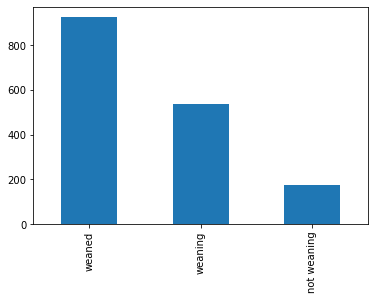

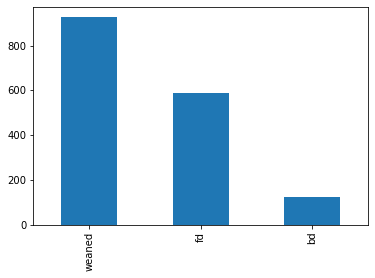

In [62]:
###C.
plt.figure()
taxonomic_assignments['diet_weaning'].value_counts().plot(kind='bar')
plt.figure()
taxonomic_assignments['diet_milk'].value_counts().plot(kind='bar')

## Decision tree classifier for milk diet and for weaning

In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def DTC(target, predictor):
    clf = DecisionTreeClassifier(random_state=0, max_depth = 50, min_samples_split = 0.01)
    #target = taxonomic_assignments['diet_milk'].fillna('weaned')
    cv_clf_milk = cross_val_score(clf, predictor, target, cv=5)
    print(sum(cv_clf_milk)/len(cv_clf_milk))
    cv_predict = cross_val_predict(clf, predictor, target, cv=5)
    class_report = classification_report(target, cv_predict, output_dict = True)
    print(classification_report(target, cv_predict, output_dict = False)) #, target_names=target_names))
    #print(class_report.index)
    conf_matrix = pd.DataFrame(confusion_matrix(target, cv_predict))
    conf_matrix.columns = list(class_report.keys())[0:-3]
    conf_matrix['index'] = list(class_report.keys())[0:-3]
    conf_matrix.set_index('index', inplace = True)
    print(conf_matrix)

In [45]:
DTC(taxonomic_assignments['diet_milk'].fillna('weaned'), taxonomic_assignments[col_names_species])
DTC(taxonomic_assignments['diet_weaning'], taxonomic_assignments[col_names_species])

0.7213914513315711
              precision    recall  f1-score   support

          bd       0.41      0.45      0.43       125
          fd       0.64      0.65      0.64       588
     no milk       0.00      0.00      0.00        30
      weaned       0.83      0.83      0.83       926

    accuracy                           0.72      1669
   macro avg       0.47      0.48      0.48      1669
weighted avg       0.72      0.72      0.72      1669

         bd   fd  no milk  weaned
index                            
bd       56   65        1       3
fd       66  381        4     137
no milk   2   13        0      15
weaned   14  135       10     767
0.7135998273722823
              precision    recall  f1-score   support

 not weaning       0.46      0.40      0.43       175
      weaned       0.82      0.84      0.83       926
     weaning       0.60      0.61      0.61       568

    accuracy                           0.71      1669
   macro avg       0.63      0.62      0.62      16

In [12]:
taxonomic_assignments[col_names_species].isnull().sum().sum()

0

## Random Forest Classifier

In [46]:
from sklearn.ensemble import RandomForestClassifier

def RFC(target, predictor):
    rfc = RandomForestClassifier(random_state=0)#, max_depth = 50, min_samples_split = 0.01)
    #target = taxonomic_assignments['diet_milk'].fillna('weaned')
    cv_rfc_milk = cross_val_score(rfc, predictor, target, cv=10)
    print(sum(cv_rfc_milk)/len(cv_rfc_milk))
    cv_predict = cross_val_predict(rfc, predictor, target, cv=5)
    class_report = classification_report(target, cv_predict, output_dict = True)
    print(classification_report(target, cv_predict, output_dict = False)) #, target_names=target_names))
    #print(class_report.index)
    conf_matrix = pd.DataFrame(confusion_matrix(target, cv_predict))
    conf_matrix.columns = list(class_report.keys())[0:-3]
    conf_matrix['index'] = list(class_report.keys())[0:-3]
    conf_matrix.set_index('index', inplace = True)
    print(conf_matrix)

In [47]:
RFC(taxonomic_assignments['diet_milk'].fillna('weaned'), taxonomic_assignments[col_names_species])
RFC(taxonomic_assignments['diet_weaning'], taxonomic_assignments[col_names_species])

0.8388247601183177


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

          bd       0.85      0.46      0.59       125
          fd       0.77      0.81      0.79       588
     no milk       0.00      0.00      0.00        30
      weaned       0.87      0.93      0.90       926

    accuracy                           0.84      1669
   macro avg       0.62      0.55      0.57      1669
weighted avg       0.82      0.84      0.82      1669

         bd   fd  no milk  weaned
index                            
bd       57   65        0       3
fd       10  474        0     104
no milk   0   11        0      19
weaned    0   62        0     864
0.8130473991775485
              precision    recall  f1-score   support

 not weaning       0.68      0.43      0.53       175
      weaned       0.88      0.94      0.91       926
     weaning       0.73      0.73      0.73       568

    accuracy                           0.81      1669
   macro avg       0.76      0.70      0.72      1669
weighted avg    

## Ideas
* transform counts to fractions
* ASV instead of taxonomic assignment
* classifier: k-means, GMM (even though not Gaussian :/), Bayes, SVM
* Dimensionality reduction: either PCA or one of those or use decision tree to get most important features/species for this classification task
* try different taxonomic levels (now have only species)
* could select features with decision tree and then build NN classifier
* Which classes are being missclassified by these models?
* Could we infer response time to change in diet of microbiome from the relapsing into weaning/not weaning/weaned in the transition period?
* Build classifier for the zygosity: build one for the first 5 months, then 5-12 then 12 and more. 3 classes: mono, di, not related, make it balanced. If this classifier does well, then it means the genetics have an influence on the microbiome. Input: the taxonomic assignment/ASV of 2 babies. 

## Repeat analysis using fractions of abundance per species

In [18]:
taxonomic_assignments_frac = taxonomic_assignments[col_names_species].div(taxonomic_assignments[col_names_species].sum(axis=1), axis=0)

In [26]:
DTC(taxonomic_assignments['diet_milk'].fillna('weaned'), taxonomic_assignments_frac)
DTC(taxonomic_assignments['diet_weaning'], taxonomic_assignments_frac)

RFC(taxonomic_assignments['diet_milk'].fillna('weaned'), taxonomic_assignments_frac)
RFC(taxonomic_assignments['diet_weaning'], taxonomic_assignments_frac)

0.7369453863357622
0.7255609263400908
0.8316391313758027
0.8136389870860687


In [19]:
taxonomic_assignments_frac

,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium;s__variabile,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Ruminococcus;s__lactaris,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__[Ruminococcus];s__gnavus,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Rothia;s__mucilaginosa,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium;s__prausnitzii,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__neonatale,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Gemmiger;s__formicilis,k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__macerans,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Clostridium;s__islandicum,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__eutactus,...,k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Atopobium;s__vaginae,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoanaerobaculum;s__orale,k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Anaerorhabdus;s__furcosa,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Selenomonas;s__noxia,k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__ureolyticus,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__agalactiae,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__europaeus,k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Bulleidia;s__moorei,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Clostridium;s__methylpentosum,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__septicum
index,,,,,,,,,,,,,,,,,,,,,
ERR1309715,0.0,0.006466,0.036298,0.000000,0.400862,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
ERR1309716,0.0,0.016798,0.456588,0.000000,0.197126,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
ERR1309717,0.0,0.000000,0.300750,0.000000,0.300500,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
ERR1309718,0.0,0.000000,0.198964,0.000000,0.389701,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
ERR1309719,0.0,0.005904,0.022502,0.000000,0.314025,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR1315696,0.0,0.000000,0.117509,0.000000,0.587740,0.000000,0.007834,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
ERR1315697,0.0,0.000000,0.185819,0.000326,0.000000,0.003097,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.002771,0.0,0.0,0.0
ERR1331873,0.0,0.000000,0.000000,0.000000,0.000000,0.034865,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


## PCA + standardize

In [15]:
from sklearn.preprocessing import StandardScaler
taxonomic_assignments_normal = pd.DataFrame(StandardScaler().fit_transform(taxonomic_assignments[col_names_species]))
taxonomic_assignments_normal.columns = taxonomic_assignments[col_names_species].columns
taxonomic_assignments_normal.set_index(taxonomic_assignments[col_names_species].index, inplace = True)

In [21]:
DTC(taxonomic_assignments['diet_milk'].fillna('weaned'), taxonomic_assignments_normal)
DTC(taxonomic_assignments['diet_weaning'], taxonomic_assignments_normal)

RFC(taxonomic_assignments['diet_milk'].fillna('weaned'), taxonomic_assignments_normal)
RFC(taxonomic_assignments['diet_weaning'], taxonomic_assignments_normal)

0.7303549527451122
0.6920027415049419
0.8388247601183177
0.8124485967823389


In [16]:
taxonomic_assignments_normal

,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium;s__variabile,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Ruminococcus;s__lactaris,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__[Ruminococcus];s__gnavus,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Rothia;s__mucilaginosa,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium;s__prausnitzii,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__neonatale,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Gemmiger;s__formicilis,k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__macerans,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Clostridium;s__islandicum,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__eutactus,...,k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Atopobium;s__vaginae,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoanaerobaculum;s__orale,k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Anaerorhabdus;s__furcosa,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Selenomonas;s__noxia,k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__ureolyticus,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__agalactiae,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__europaeus,k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Bulleidia;s__moorei,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Clostridium;s__methylpentosum,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__septicum
index,,,,,,,,,,,,,,,,,,,,,
ERR1309715,-0.144532,0.534559,-0.452721,-0.211927,1.416353,-0.198385,-0.317228,-0.077032,-0.025231,-0.153702,...,-0.024485,-0.055225,-0.044723,-0.024485,-0.033602,-0.044228,-0.070759,-0.08633,-0.065374,-0.065275
ERR1309716,-0.144532,0.913905,0.625450,-0.211927,-0.223863,-0.198385,-0.317228,-0.077032,-0.025231,-0.153702,...,-0.024485,-0.055225,-0.044723,-0.024485,-0.033602,-0.044228,-0.070759,-0.08633,-0.065374,-0.065275
ERR1309717,-0.144532,-0.297085,0.039027,-0.211927,-0.077782,-0.198385,-0.317228,-0.077032,-0.025231,-0.153702,...,-0.024485,-0.055225,-0.044723,-0.024485,-0.033602,-0.044228,-0.070759,-0.08633,-0.065374,-0.065275
ERR1309718,-0.144532,-0.297085,0.096389,-0.211927,0.791020,-0.198385,-0.317228,-0.077032,-0.025231,-0.153702,...,-0.024485,-0.055225,-0.044723,-0.024485,-0.033602,-0.044228,-0.070759,-0.08633,-0.065374,-0.065275
ERR1309719,-0.144532,0.476198,-0.518436,-0.211927,0.958246,-0.198385,-0.317228,-0.077032,-0.025231,-0.153702,...,-0.024485,-0.055225,-0.044723,-0.024485,-0.033602,-0.044228,-0.070759,-0.08633,-0.065374,-0.065275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR1315696,-0.144532,-0.297085,-0.296787,-0.211927,1.074855,-0.198385,-0.147784,-0.077032,-0.025231,-0.153702,...,-0.024485,-0.055225,-0.044723,-0.024485,-0.033602,-0.044228,-0.070759,-0.08633,-0.065374,-0.065275
ERR1315697,-0.144532,-0.297085,0.003942,0.392698,-0.847914,-0.134881,-0.317228,-0.077032,-0.025231,-0.153702,...,-0.024485,-0.055225,-0.044723,-0.024485,-0.033602,-0.044228,8.734702,-0.08633,-0.065374,-0.065275
ERR1331873,-0.144532,-0.297085,-0.630931,-0.211927,-0.847914,0.169267,-0.317228,-0.077032,-0.025231,-0.153702,...,-0.024485,-0.055225,-0.044723,-0.024485,-0.033602,-0.044228,-0.070759,-0.08633,-0.065374,-0.065275


In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(taxonomic_assignments_normal)
principalComponents = pd.DataFrame(principalComponents)
principalComponents.set_index(taxonomic_assignments[col_names_species].index, inplace = True)

principalComponents_nonnormal = pca.fit_transform(taxonomic_assignments[col_names_species])
principalComponents_nonnormal = pd.DataFrame(principalComponents_nonnormal)
principalComponents_nonnormal.set_index(taxonomic_assignments[col_names_species].index, inplace = True)

principalComponents.describe()
principalComponents.head()

,0,1
index,,
ERR1309715,-0.692556,-0.032388
ERR1309716,-0.161841,-0.023096
ERR1309717,0.352637,-0.019653
ERR1309718,0.013562,0.035745
ERR1309719,-0.779891,0.083294


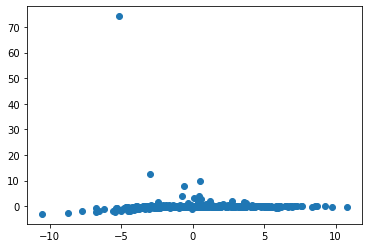

In [18]:
#plt.scatter(np.log(principalComponents.iloc[:,0]), np.log(principalComponents.iloc[:,1]))
plt.scatter(principalComponents.iloc[:,0], principalComponents.iloc[:,1])

{'weaning': 'red', 'not weaning': 'green', 'weaned': 'blue'}
weaning
1669
not weaning
1669
weaned
1669


(-5.0, 15.0)

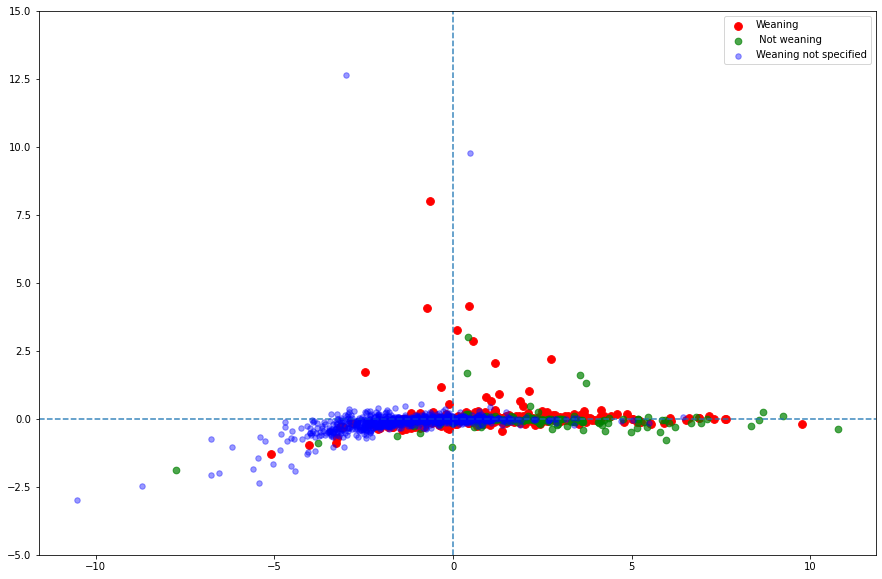

In [19]:
colours_weaning = {'weaning':'red', 'not weaning':'green', 'weaned':'blue'}#, 'other':'black'}
print(colours_weaning)
labels = ['Weaning', ' Not weaning', 'Weaning not specified']
fig, ax = plt.subplots(figsize = (15,10))
i=0
for key in colours_weaning:
    indices = (taxonomic_assignments['diet_weaning'] == key)
    print(key)
    print(len(indices))
    PCAs = principalComponents.loc[indices, ]
    ax.scatter(PCAs.iloc[:,0], PCAs.iloc[:,1], 
               color = colours_weaning[key], label = labels[i], s = 60-i*15,
               zorder = i, alpha = 1-i*0.3)
    ax.axhline(0, linestyle = '--', alpha = 0.4)
    ax.axvline(0, linestyle = '--', alpha = 0.4)
    i=i+1
ax.legend()
ax.set_ylim([-5, 15]) #one outlier at 70

(-5.0, 15.0)

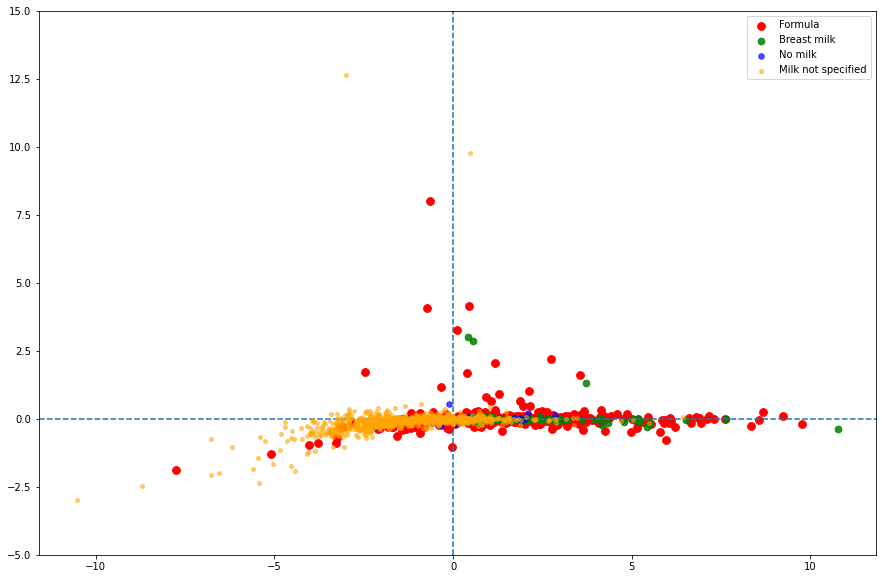

In [20]:
color_formula_breast = {'fd': 'red', 'bd': 'green', 'no milk': 'blue', 'weaned': 'orange'}
labels = ['Formula', 'Breast milk', 'No milk', 'Milk not specified']

fig, ax = plt.subplots(figsize = (15,10))
i=0
for key in color_formula_breast:
    indices = (taxonomic_assignments['diet_milk'] == key)
    PCAs = principalComponents.loc[indices, ]
    ax.scatter(PCAs.iloc[:,0], PCAs.iloc[:,1], 
               color = color_formula_breast[key], label = labels[i], s = 60-i*15,
                zorder = i, alpha = 1-i*0.15)
    ax.axhline(0, linestyle = '--', alpha = 0.4)
    ax.axvline(0, linestyle = '--', alpha = 0.4)
    i=i+1
ax.legend()
ax.set_ylim([-5, 15]) #one outlier at 70

In [110]:
(taxonomic_assignments['diet_weaning'] == key).sum()

1669